In [1]:
from scipy import stats, optimize
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [16, 6]
import pandas as pd
import numpy as np
from IPython.display import Image
from copy import deepcopy

##### First we generate dates and separately highlight the dates where we expect to see credit quality deterioration. In this example we focus on 3x3 IFRS 9 style matrices

In [2]:
dates = pd.date_range('2015-01-01', '2024-10-01', freq = 'QS').strftime('%Y-%m-%d')
covid = ['2020-04-01', '2020-07-01', '2020-10-01']
dims = 3 # 3x3 dimensions for IFRS 9 style matrix

##### Next we create a function to generate dummy transition matrices, we set up higher probabilities for diagonal entries and specify lower probabilities for our imaginary Covid stress periods

In [3]:
def generate_dummy_matrices(period):
    if period == 'normal':
        matrix_df = pd.DataFrame(np.zeros((dims, dims)), columns=[dim + 1 for dim in range(dims)], 
                                index=[dim + 1 for dim in range(dims)])
        for i in range(3):
            if i == 0:
                matrix_df.iloc[i, i] = np.random.uniform(0.95, 0.99, 1)
            else:
                matrix_df.iloc[i, i] = np.random.uniform(0.80, 0.90, 1)
            remaining_prob = 1 - matrix_df.iloc[i, i]
            other_indices = [j for j in range(3) if j != i]
            matrix_df.iloc[i, other_indices] = np.random.dirichlet([1, 1]) * remaining_prob
        return matrix_df
    else:
        matrix_df = pd.DataFrame(np.zeros((dims, dims)), columns=[dim + 1 for dim in range(dims)], 
                                index=[dim + 1 for dim in range(dims)])
        for i in range(3):
            if i == 0:
                matrix_df.iloc[i, i] = np.random.uniform(0.85, 0.90, 1)
            else:
                matrix_df.iloc[i, i] = np.random.uniform(0.70, 0.80, 1)
            remaining_prob = 1 - matrix_df.iloc[i, i]
            other_indices = [j for j in range(3) if j != i]
            matrix_df.iloc[i, other_indices] = np.random.dirichlet([1, 1]) * remaining_prob
        return matrix_df

In [4]:
matrix_dict = {}
for date in dates:
    if date not in covid:
        matrix_dict[date] = generate_dummy_matrices(period = 'normal')
    else:
        matrix_dict[date] = generate_dummy_matrices(period = 'covid')

##### An important step is to set up matrices representing number of borrowers that transitioned to different credit stages between quarters. For demonstration purposes, in this example we set up fixed numbers for different stages, however in a real application we would need the matrices with the numbers of transitioned borrowers to be calculated before probability matrices

In [5]:
n = deepcopy(matrix_dict)
number_of_firms = {0:10000, 1:1000, 2:800}
for date in n.keys():
    for i in range(dims):
        n[date].iloc[i, ] = list(map(int, n[date].iloc[i, ].values * number_of_firms[i]))

##### Our next step is to use our quarterly transition matrices to calculate historical average transitions and thresholds using inverse cumulative function of standard normal variable

In [6]:
tr_av = pd.concat(matrix_dict.values())
tr_av = tr_av.groupby(level=0).mean()
tr_av # this is our historical average transition matrix

,1,2,3
1,0.963781,0.016739,0.019480
2,0.075565,0.840039,0.084395
3,0.077700,0.080868,0.841432


In [7]:
historical_thresholds=pd.DataFrame(np.zeros_like(tr_av))
for i in range(tr_av.shape[0]): # 0,1,2
    for j in range(tr_av.shape[1]): # 0,1,2
        if j>0:
            historical_thresholds.iloc[i,j] = stats.norm.ppf(sum(tr_av.iloc[i,j:]))
            
historical_thresholds=historical_thresholds.replace([0], np.inf)

historical_thresholds.index = tr_av.index
historical_thresholds.columns = tr_av.columns
historical_thresholds # This are our historical transition thresholds

,1,2,3
1,inf,-1.796354,-2.064617
2,inf,1.435549,-1.376099
3,inf,1.420715,1.000362


##### The calculation formula uses factor correlation (rho) for calculations. For demonstration purposes we create a gridmatrix with different potential values of rho, the optimal Z factor will be calculated for each quarter and each potential value of correlation

In [8]:
gridmatrix=pd.DataFrame(index=dates, columns=np.linspace(0, 0.3, 21))
gridmatrix.head(5)

,0.000,0.015,0.030,0.045,0.060,0.075,0.090,0.105,0.120,0.135,...,0.165,0.180,0.195,0.210,0.225,0.240,0.255,0.270,0.285,0.300
2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### As stated in Belkin et al. (1998) the optimisation problem is to find the optimal values of Z that represent the magnitude of the shock that shift the transition matrix away from historical averages. We find optimal shifts that make fitted values closer to historically observed ones

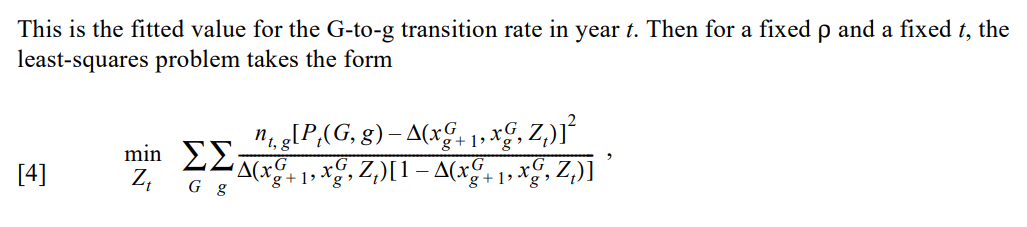

In [9]:
%matplotlib inline
Image('Formula.png')

#### Hence, we define a loss function as stated above, where n represents the number of firms that changed the credit stage, P_t(G,g) are historical averages and the remainings terms are our fitted values for given values of Z and rho

In [10]:
def loss(z, date, rho):
    matrix_t = n[date]
    matrix_p = matrix_dict[date]
    shifted = historical_thresholds.sub(np.repeat(rho**0.5*z, dims))/((1-rho)**0.5)
    shiftedP = shifted.copy()
    
    for i in range(shifted.shape[0]): 
            for j in range(shifted.shape[1]): 
                if j < shifted.shape[1]-1:
                    shiftedP.iloc[i,j] = stats.norm.cdf(shifted.iloc[i,j]) - stats.norm.cdf(shifted.iloc[i,j+1])
                else:
                    shiftedP.iloc[i,j] = stats.norm.cdf(shifted.iloc[i,j])

            shiftedP.iloc[i,0] = 1 - stats.norm.cdf(shifted.iloc[i,1])

    res=np.sum(np.sum((matrix_t.values*(matrix_p-shiftedP)**2)/
                            (shiftedP*(1-shiftedP)) ,axis = None))
    return res

##### We now call our function for various values of Z and rho given in our gridmatrix, and minimize the loss function usin scipy's optimize.minimize

In [11]:
for rho in tqdm(gridmatrix.columns): 
    for date in dates: 
        def call_loss(z):
            return loss(z, date, float(rho))
        
        gridmatrix.loc[gridmatrix.index == date, rho] = optimize.minimize(call_loss, x0=0).x[0]

100%|██████████| 21/21 [01:17<00:00,  3.68s/it]


##### We now plot our optimal Z factors. Since our dummy transition matrices are randomly generated, there is a huge volatility in the optimal Z factor. However, the deterioration of credit quality that we created ourselves is clearly seen during Covid periods

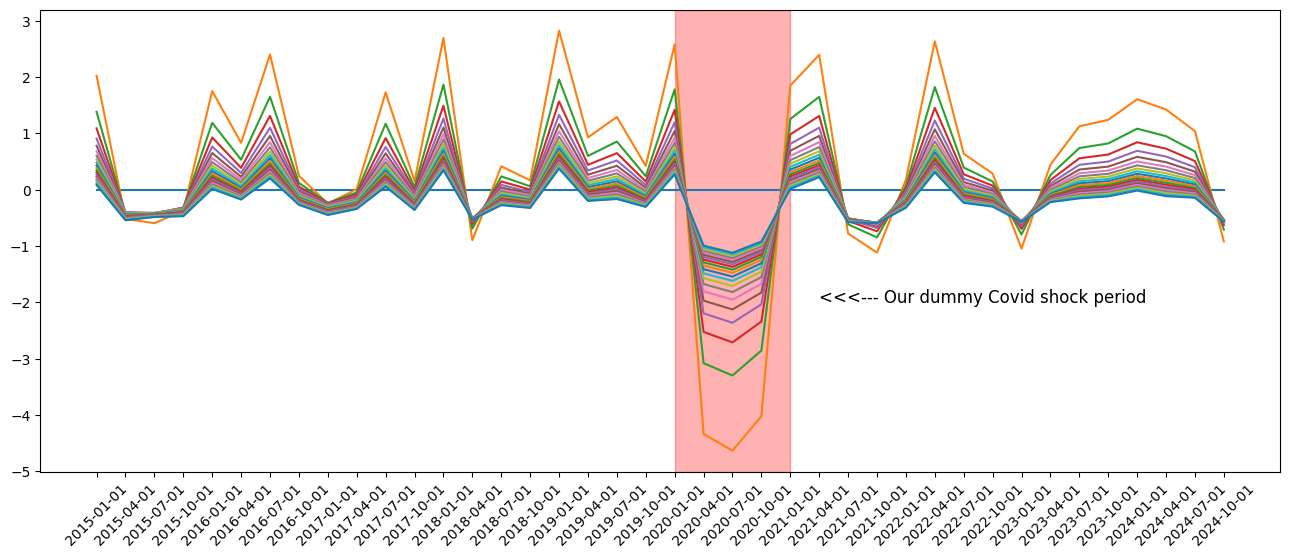

In [12]:
plt.plot(gridmatrix)
plt.xticks(rotation=45)
plt.axvspan('2020-01-01', '2021-01-01', color='red', alpha=0.3)
plt.text('2021-04-01', -2, '<<<--- Our dummy Covid shock period', fontsize = 12)
plt.show()

##### Depending on our choice of correlation factor, we can select a preferred Z factor. In this example, we select a Z factor that is closer to standard normal distribution by looking at mean and standard deviation

In [13]:
Z_FINAL=gridmatrix.iloc[:, np.argmin(abs(gridmatrix.mean())+(abs(gridmatrix.std()-1)))]

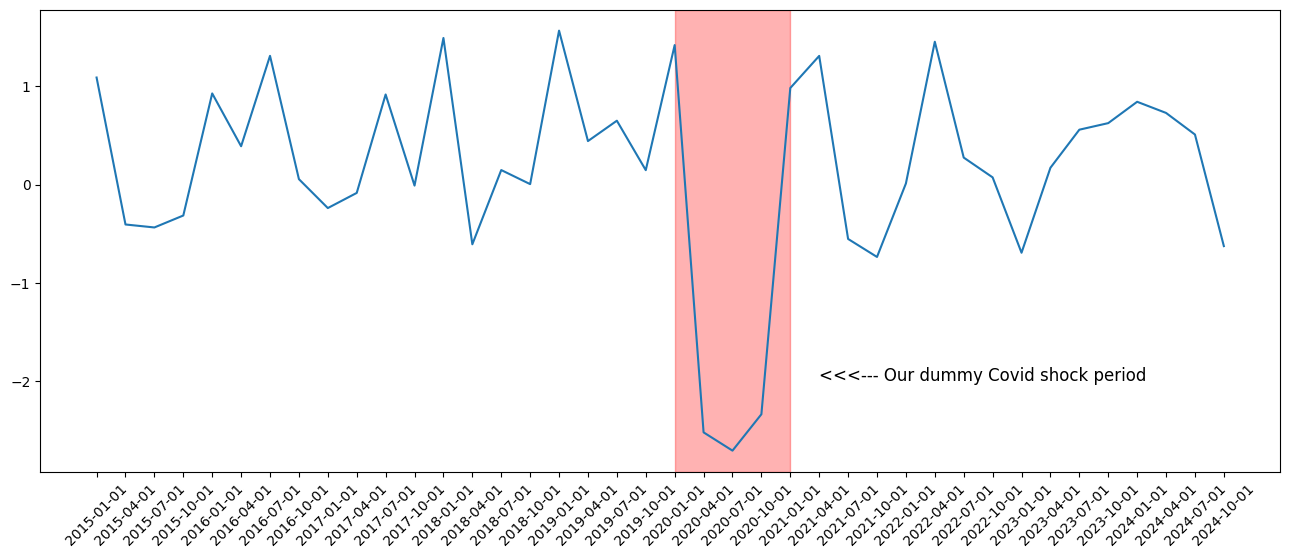

In [14]:
plt.plot(Z_FINAL)
plt.xticks(rotation=45)
plt.axvspan('2020-01-01', '2021-01-01', color='red', alpha=0.3)
plt.text('2021-04-01', -2, '<<<--- Our dummy Covid shock period', fontsize = 12)
plt.show()

##### In real applications, we can set up a regression model of our Z-factor to forecast it under various macroeconomic scenarios for stress testing purposes.